In [1]:
import numpy as np
from scipy.fft import fft, rfft, fftfreq, fftshift
from scipy.signal import correlate
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('./nikhils_plot_style.mplstyle')

# Simulating a signal with some random noise

In [3]:
sampling_rate = 1_000_000 # Hz
sampling_time = 1 # seconds
N = sampling_rate*sampling_time
V = np.random.randn(N) # time series with one million samples
time = np.arange(0,sampling_time,1/sampling_rate)

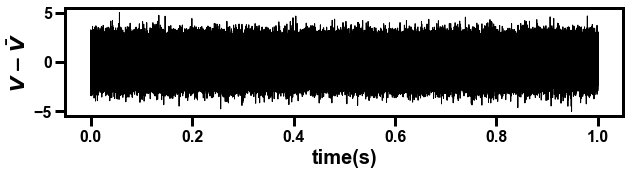

In [4]:
fig, ax = plt.subplots(1,1, figsize = (10,2))
ax.plot(time, V)
ax.set_xlabel('time(s)')
ax.set_ylabel('$V-\\bar{V}$')
plt.show()


# Calculate auto-correlation

In [5]:
auto_corr = correlate(V,V)

In [6]:
auto_corr

array([-3.89689933, -0.39638642,  0.84716754, ...,  0.84716754,
       -0.39638642, -3.89689933])

In [7]:
len(auto_corr)

1999999

# Calculate the power spectral density S

In [8]:
S = fft(auto_corr)

In [9]:
S

array([1463223.98495016-0.j        , -820584.86687662-1.28897234j,
        214375.05398105+0.67347943j, ..., -848517.32867841+3.99854571j,
        214375.05398105-0.67347943j, -820584.86687662+1.28897234j])

In [10]:
freq = fftfreq(len(auto_corr), d=1/sampling_rate)

/Users/NikhilStuff/anaconda3/envs/erdos_env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


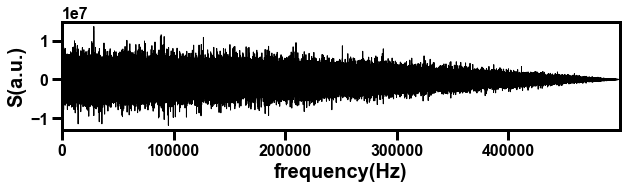

In [11]:
fig, ax = plt.subplots(1,1, figsize = (10,2))
ax.plot(freq, S)
ax.set_xlabel('frequency(Hz)')
ax.set_ylabel('S(a.u.)')
ax.set_xlim(0, freq.max())
plt.show()

# Simulated data

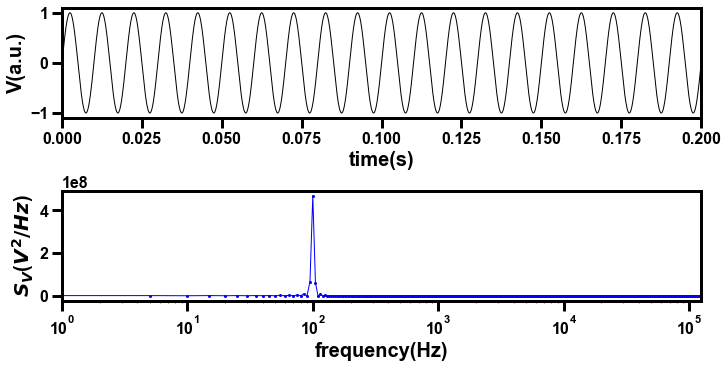

In [18]:
sampling_rate = 0.25e6 # Hz
sampling_time = 0.2 # seconds
N = sampling_rate*sampling_time
time = np.arange(0,sampling_time,1/sampling_rate)

V = np.sin(2*np.pi*100*time) # sine signal with frequency 100Hz

V = V - np.mean(V) #removing DC component

auto_corr = correlate(V,V, mode="same") # mode="same" returns the same length as the input i.e. lags start from 0 to (N-1)*dt
S = fft(auto_corr)
S = S[:S.size//2]
freq = fftfreq(len(auto_corr), d=1/sampling_rate)
freq = freq[:freq.size//2]

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,5), constrained_layout=True)
ax1.plot(time, V)
ax1.set_xlim(time.min(),time.max())
ax1.set_xlabel('time(s)')
ax1.set_ylabel('V(a.u.)')

ax2.plot(freq, np.absolute(S), 'bo-', markersize=2)
ax2.set_xlabel('frequency(Hz)')
ax2.set_ylabel('$S_V$($V^2/Hz$)')
ax2.set_xlim(1, freq.max())
ax2.set_xscale('log')
# ax2.set_yscale('log')
plt.show()


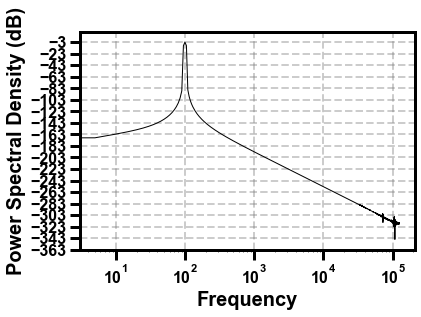

In [19]:
S,frequencies = plt.psd(V, Fs=sampling_rate, NFFT=len(V), detrend='mean', scale_by_freq=False)
plt.xscale('log')

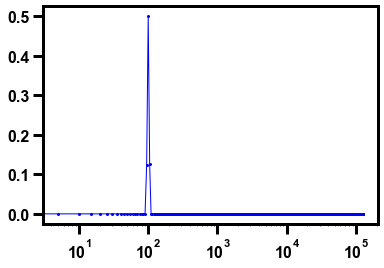

In [20]:
# plt.plot(frequencies, 10*np.log10(S))
plt.plot(frequencies, S, 'bo-', markersize=2)
plt.xscale('log')

# Trying with actual data from scope

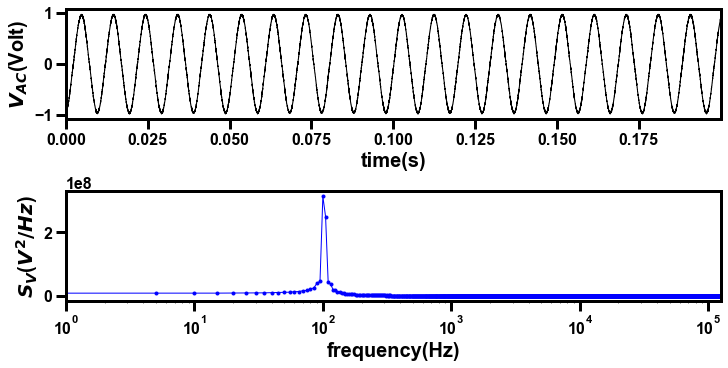

In [69]:
fp="./data/scope_1.csv"
df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"])
df.head()

sampling_time = df["time"].max()-df["time"].min() # seconds
N = df.shape[0]
sampling_rate = N/sampling_time # Hz
time = df["time"].to_numpy() - df["time"].min()

V = df["voltage"].to_numpy() # sine signal with frequency 500Hz

V = V - np.mean(V)

auto_corr = correlate(V,V, mode="same") # mode="same" returns the same length as the input i.e. lags start from 0 to (N-1)*dt
S = fft(auto_corr)
S = S[:S.size//2]
freq = fftfreq(len(auto_corr), d=1/sampling_rate)
freq = freq[:freq.size//2]

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,5), constrained_layout=True)
ax1.plot(time, V)
ax1.set_xlim(time.min(),time.max())
ax1.set_xlabel('time(s)')
ax1.set_ylabel('$V_{AC}$(Volt)')

ax2.plot(freq, np.absolute(S), 'bo-', markersize=3)
ax2.set_xlabel('frequency(Hz)')
ax2.set_ylabel('$S_V$($V^2/Hz$)')
ax2.set_xlim(1, freq.max())
ax2.set_xscale('log')
# ax2.set_yscale('log')
plt.show()


In [70]:
sampling_rate/1e6 # MHz

0.250005000100002

# 10 kOhm resistor data

1.5 Volt battery with 10 M Ohm resistor in series gives 1.5 uA of current.

This current flows through a 10 kOhm resistor to give a voltage drop of V = 1.5 uA x 10 kOhm = 1.5 mV

The thermal noise should be equal to $S_V(f)$ = 4kTR = 104 meV x 10 kOhm = 1.664e-16 V^2/Hz


RMS voltage = 0.016 V


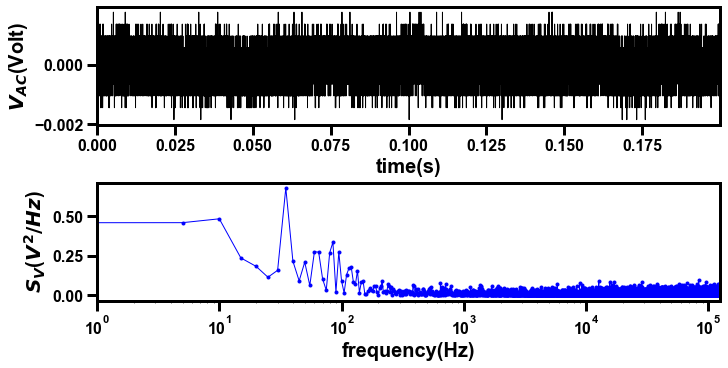

In [102]:
fp="./data/scope_2.csv" 
df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"])
df.head()

sampling_time = df["time"].max()-df["time"].min() # seconds
N = df.shape[0]
sampling_rate = N/sampling_time # Hz
time = df["time"].to_numpy() - df["time"].min()

V = df["voltage"].to_numpy() # sine signal with frequency 500Hz

print("RMS voltage = {:.3f} V".format(np.sqrt(np.mean(V**2))))
V = V - np.mean(V)

auto_corr = correlate(V,V, mode="same") # mode="same" returns the same length as the input i.e. lags start from 0 to (N-1)*dt
S = fft(auto_corr)
S = S[:S.size//2]
freq = fftfreq(len(auto_corr), d=1/sampling_rate)
freq = freq[:freq.size//2]

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,5), constrained_layout=True)
ax1.plot(time, V)
ax1.set_xlim(time.min(),time.max())
ax1.set_xlabel('time(s)')
ax1.set_ylabel('$V_{AC}$(Volt)')

ax2.plot(freq, np.absolute(S), 'bo-', markersize=3)
ax2.set_xlabel('frequency(Hz)')
ax2.set_ylabel('$S_V$($V^2/Hz$)')
ax2.set_xlim(1, freq.max())
ax2.set_xscale('log')
# ax2.set_yscale('log')
plt.show()


RMS voltage = 0.016 V


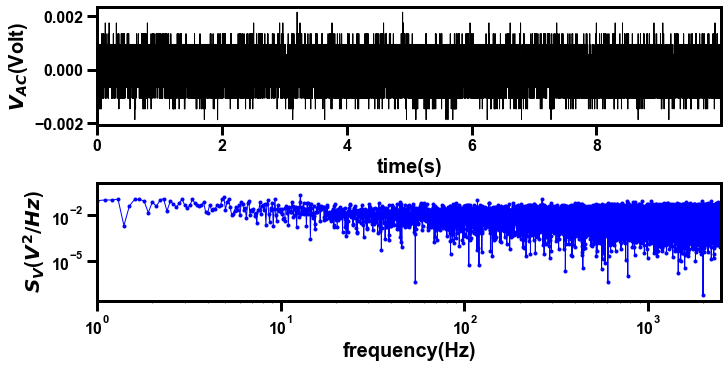

In [21]:
fp="./data/scope_4.csv" 
df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"])
df.head()

sampling_time = df["time"].max()-df["time"].min() # seconds
N = df.shape[0]
sampling_rate = N/sampling_time # Hz
time = df["time"].to_numpy() - df["time"].min()

V = df["voltage"].to_numpy() # sine signal with frequency 500Hz

print("RMS voltage = {:.3f} V".format(np.sqrt(np.mean(V**2))))
V = V - np.mean(V)

auto_corr = correlate(V,V, mode="same") # mode="same" returns the same length as the input i.e. lags start from 0 to (N-1)*dt
S = fft(auto_corr)
S = S[:S.size//2]
freq = fftfreq(len(auto_corr), d=1/sampling_rate)
freq = freq[:freq.size//2]

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,5), constrained_layout=True)
ax1.plot(time, V)
ax1.set_xlim(time.min(),time.max())
ax1.set_xlabel('time(s)')
ax1.set_ylabel('$V_{AC}$(Volt)')

ax2.plot(freq, np.absolute(S), 'bo-', markersize=3)
ax2.set_xlabel('frequency(Hz)')
ax2.set_ylabel('$S_V$($V^2/Hz$)')
ax2.set_xlim(1, freq.max())
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.show()


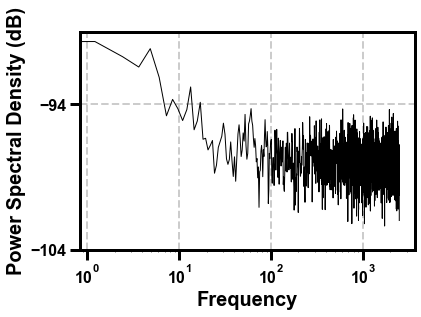

In [32]:
S, frequencies = plt.psd(V, Fs=sampling_rate, NFFT=256*16, detrend='mean', scale_by_freq=False)
plt.xscale('log')

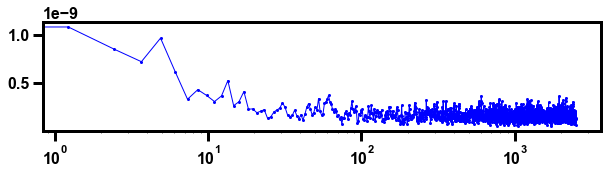

In [35]:
plt.plot(frequencies, S, 'bo-', markersize=2, figure=plt.figure(figsize=(10,2)))
plt.xscale('log')
# plt.xlim(1e2, 1e3)

## 10 k Ohm background

RMS voltage = 0.001 V


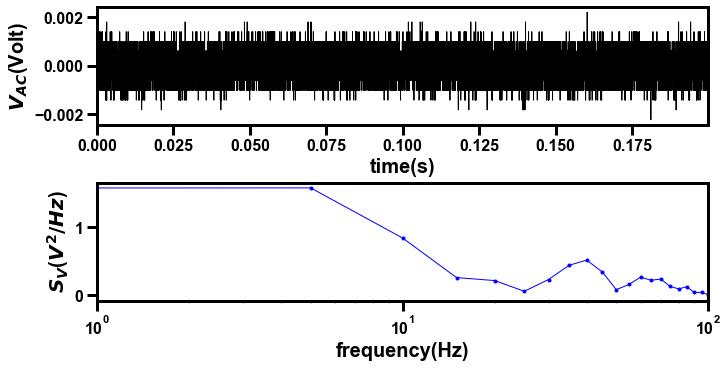

In [92]:
fp="./data/scope_3.csv"
df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"])
df.head()

sampling_time = df["time"].max()-df["time"].min() # seconds
N = df.shape[0]
sampling_rate = N/sampling_time # Hz
time = df["time"].to_numpy() - df["time"].min()

V = df["voltage"].to_numpy() # sine signal with frequency 500Hz

print("RMS voltage = {:.3f} V".format(np.sqrt(np.mean(V**2))))
V = V - np.mean(V)

auto_corr = correlate(V,V, mode="same") # mode="same" returns the same length as the input i.e. lags start from 0 to (N-1)*dt
S = fft(auto_corr)
S = S[:S.size//2]
freq = fftfreq(len(auto_corr), d=1/sampling_rate)
freq = freq[:freq.size//2]

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,5), constrained_layout=True)
ax1.plot(time, V)
ax1.set_xlim(time.min(),time.max())
ax1.set_xlabel('time(s)')
ax1.set_ylabel('$V_{AC}$(Volt)')

ax2.plot(freq, np.absolute(S), 'bo-', markersize=3)
ax2.set_xlabel('frequency(Hz)')
ax2.set_ylabel('$S_V$($V^2/Hz$)')
ax2.set_xlim(1, 100)
ax2.set_xscale('log')
# ax2.set_yscale('log')
plt.show()
